<a href="https://colab.research.google.com/github/javierbaldrich/5510/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data-driven TV ad for a bank 

My final project will be based on  a dataset from Kaggle (https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation) which consists of transactions performed by a bank's customers.

The idea is to use a k-means clustering model to select target customers that the bank's marketing team can try to reach out to in a television commercial. Based on the 4 centroids defined by our model, the bank will select demographically appropriate actors, who will in turn be filmend performing  financially appropriate transactions vis-a-vis the model centroids.

Let's start by importing some libraries and taking a look at the dataset.

In [1]:
import pandas as pd
from datetime import date
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import drive 

In [2]:
drive.mount('/content/gdrive')
trx_df = pd.read_csv('/content/gdrive/MyDrive/5510/final_proj/bank_transactions.csv')
# trx_df = trx_df.sample(22000)

# Sample 10 records
print(trx_df.sample(10).to_string())
# Field descriptions
print(trx_df.describe(include='all').to_string())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
       TransactionID CustomerID CustomerDOB CustGender CustLocation  CustAccountBalance TransactionDate  TransactionTime  TransactionAmount (INR)
455402       T455403   C2325651     16/3/72          M       MUMBAI            10744.47         16/8/16           185141                  1130.00
67098         T67099   C3049669     12/5/88          M     DEHRADUN            16267.76          2/8/16           145815                    20.00
426616       T426617   C1123552    28/11/92          M       MUMBAI            87292.58         17/8/16           170410                   200.00
996063       T996064   C6946891     25/7/90          F       MUMBAI              211.90         14/9/16            93312                   653.00
29110         T29111   C5038218      2/3/56          M     GUWAHATI            20815.46         25/9/16           204032                   

# Fields with minimal or no manipulation needed
**CustAccountBalance**

Violin plot for all account balances (above) and for the bottom 90% of balances (below). Second chart is provided to get a better understanding of the distribution 

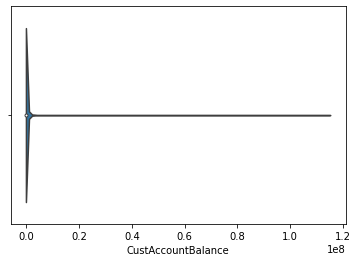

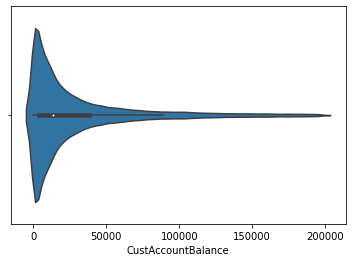

In [3]:
sns.violinplot(x=trx_df['CustAccountBalance'])
plt.show()
y = trx_df[trx_df['CustAccountBalance']<trx_df['CustAccountBalance'].quantile(0.90)]
sns.violinplot(x=y['CustAccountBalance'])
plt.show()

**Transaction amounts**

Violin plot for all transaction amounts (above) and for the bottom 90% of transactions (below). Second chart is provided to get a better understanding of the distribution 

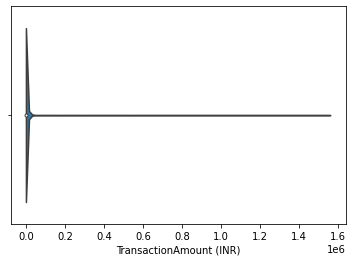

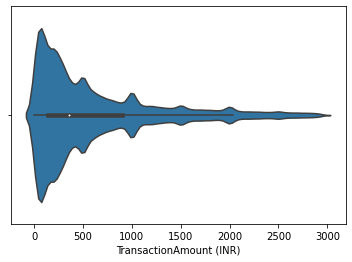

In [4]:
sns.violinplot(x=trx_df['TransactionAmount (INR)'])
plt.show()
y = trx_df[trx_df['TransactionAmount (INR)']<trx_df['TransactionAmount (INR)'].quantile(0.90)]
sns.violinplot(x=y['TransactionAmount (INR)'])
plt.show()

**Gender**

As we can se below, there  is only one instance that drifts away from the M-binary nature of the field.

M    765530
F    281936
T         1
Name: CustGender, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


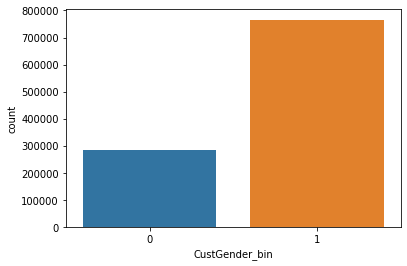

In [5]:
print(trx_df['CustGender'].value_counts())
trx_df = trx_df[trx_df['CustGender'] != 'T']
trx_df['CustGender_bin'] = 0
trx_df.loc[trx_df['CustGender'] == 'M', 'CustGender_bin'] = 1
sns.countplot(x=trx_df['CustGender_bin'])

# TransactionTime

For this field, the histogram shows a interference in the distribution marked by the distinct spikes in counts.
This is because the last two digits (and the middle two as well) represent seconds and hours. Therefore, they only reach 60 (as opposed to 99 in a normal number).

Below, we fix that. And we offset the time 5 hours into the past in order to capture the minimum values at the ends of the distribution.

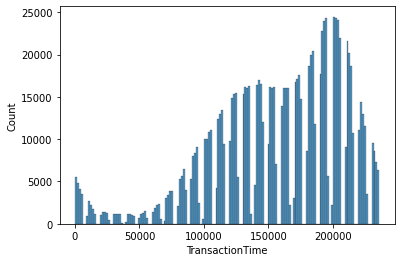

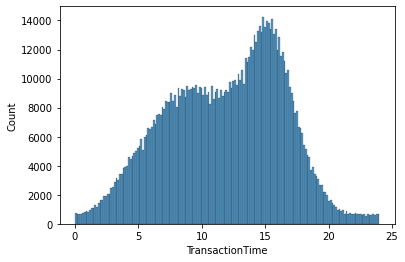

In [6]:
sns.histplot(data=trx_df, x="TransactionTime")
plt.show()
trx_df['TransactionTime'] = np.floor(trx_df['TransactionTime']/10000) + round((trx_df['TransactionTime']/10000) % 1/0.60, 2) - 5
trx_df.loc[trx_df['TransactionTime'] < 0, 'TransactionTime'] = trx_df['TransactionTime'] + 24
sns.histplot(data=trx_df, x="TransactionTime")
plt.show()

# Data cleaning and overview of the remaining fields

Before reducing the number of missing values, we will look at CustomerDOB, which presented some irregularities in the df.describe() function.

The mode for the CustomerDOB field is an unreasonable date (1/1/1800). The records that presernt this value should really have a NULL value in them.

In [7]:
trx_df.loc[trx_df['CustomerDOB'] == '1/1/1800', 'CustomerDOB'] = np.nan

We will now work on missing values.

Below is a bar chart representing the percentage of records with NULL values for each field that has any. The field that stands out is CustomerDOB (mostly due to the adjustment we made in the cell above).

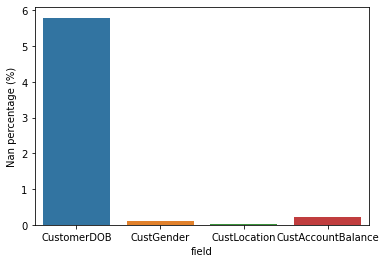

In [8]:
nans_series = trx_df.isna().sum()
nans = pd.DataFrame()
nans['field'] = nans_series.index
nans['count'] = nans_series.to_list()
nans = nans.loc[nans['count'] != 0]
nans['Nan percentage (%)'] = 100*nans['count']/trx_df.shape[0]
sns.barplot(data=nans, x='field', y='Nan percentage (%)')
plt.show()

Below we will impute NULL values using the mode value for that filed in the records labeld with the same Customer ID.

That is to say, if a customer has three transactions, two with a CustomerDOB of '01/01/1992' and one with a CustomerDOB of NULL, we will impute that NULL value with '01/01/1992'.

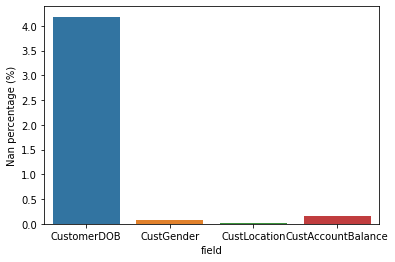

In [9]:
for nan_field in nans['field'].to_list():
    sub_nans = trx_df[trx_df[nan_field].isna()]
    customers = sub_nans['CustomerID'].unique()
    sub_replacements = trx_df[(~trx_df[nan_field].isna()) & (trx_df['CustomerID'].isin(customers))]
    sub_replacements = sub_replacements[['CustomerID', nan_field]]
    sub_replacements = sub_replacements.groupby(['CustomerID']).agg(lambda x: x.value_counts().index[0])
    sub_replacements = sub_replacements.rename(columns={nan_field: 'tmp'})
    trx_df = trx_df.merge(sub_replacements, on='CustomerID', how='left')
    trx_df[nan_field] = trx_df[nan_field].combine_first(trx_df['tmp'])
    trx_df = trx_df.drop('tmp', axis=1)
nans_series = trx_df.isna().sum()
nans = pd.DataFrame()
nans['field'] = nans_series.index
nans['count'] = nans_series.to_list()
nans = nans.loc[nans['count'] != 0]
nans['Nan percentage (%)'] = 100*nans['count']/trx_df.shape[0]
sns.barplot(data=nans, x='field', y='Nan percentage (%)')
plt.show()

The bar chart above shows that about 20% of the missing values could reasonably be imputed using the mode value for that filed in the records labeld with the same Customer ID.

Next, we will remove the remaining missings values and transform CustomerDOB and TransactionDate into pandas datatime objects.

In [10]:
trx_df = trx_df.dropna()
trx_df['CustomerDOB'] = pd.to_datetime(trx_df['CustomerDOB'], errors='coerce')
trx_df['TransactionDate'] = pd.to_datetime(trx_df['TransactionDate'], errors='coerce')

And we will create two new fields: Age (from CustomerDOB) and IsWeekday (from TransactionDate)

In [11]:
def age(customer_dob):
    today = pd.Timestamp.today()
    res = pd.Timedelta(today - customer_dob).days
    return res/365 if res > 0 else 100+res/365
trx_df['Age'] = trx_df['CustomerDOB'].apply(age)
trx_df['TransactionDayName'] = trx_df['TransactionDate'].dt.day_name()
trx_df['IsWeekday'] = 1
trx_df.loc[trx_df['TransactionDayName'].isin(['Saturday', 'Sunday']), 'IsWeekday'] = 0



We next drop the superfluous and categorical variables. And we normalize the dataset.

In [12]:
trx_df = trx_df.drop(['TransactionID', 'CustomerID', 'CustomerDOB', 'TransactionDate', 'TransactionDayName', 'CustLocation', 'CustGender'], axis=1)
scaled_df = StandardScaler().fit_transform(trx_df)
scaled_df = pd.DataFrame(scaled_df, columns=trx_df.columns)

After our manipulation these are the fields we are left with:

In [13]:
print(scaled_df.describe(include='all').to_string())

       CustAccountBalance  TransactionTime  TransactionAmount (INR)  CustGender_bin           Age     IsWeekday
count        1.002908e+06     1.002908e+06             1.002908e+06    1.002908e+06  1.002908e+06  1.002908e+06
mean        -2.903361e-17     2.811258e-17            -3.987339e-17    8.517376e-17 -1.949319e-15  6.348003e-18
std          1.000000e+00     1.000000e+00             1.000000e+00    1.000000e+00  1.000000e+00  1.000000e+00
min         -1.314404e-01    -2.580787e+00            -2.377877e-01   -1.624219e+00 -4.267953e+00 -1.572944e+00
25%         -1.258443e-01    -7.647385e-01            -2.130237e-01   -1.624219e+00 -6.718235e-01 -1.572944e+00
50%         -1.118154e-01     1.085286e-01            -1.674899e-01    6.156805e-01 -2.558381e-01  6.357505e-01
75%         -6.509297e-02     7.732544e-01            -5.405474e-02    6.156805e-01  3.864509e-01  6.357505e-01
max          1.389805e+02     2.630576e+00             2.490056e+02    6.156805e-01  7.084473e+00  6.357

# Unspuervised model

Below we train a k-means model to create 4 clusters that will represent our 4 marketing targets.

In [17]:
model = KMeans(n_clusters=4, random_state=42).fit(scaled_df)

df_mn = trx_df.mean()
df_sd = trx_df.std()

for idx, centroid in enumerate(model.cluster_centers_):
  print('Target customer #', idx + 1, ' will have the following characteristics:')
  print('   Account balance:', round((df_mn[0] + centroid[0] * df_sd[0])/1000), 'thousand INR')
  print('   Transaction Time:', round(df_mn[1] + centroid[1] * df_sd[1]))
  print('   Transaction Amount:', round(df_mn[2] + centroid[2] * df_sd[2]), 'INR')
  if round(df_mn[3] + centroid[3] * df_sd[3]) == 1:
    print('   Gender: Male')
  else:
    print('   Gender: Female')
  print('   Age:', round(df_mn[4] + centroid[4] * df_sd[4]))
  print('   IsWeekday:', round(df_mn[5] + centroid[5] * df_sd[5]))

Target customer # 1  will have the following characteristics:
   Account balance: 108 thousand INR
   Transaction Time: 12
   Transaction Amount: 1471 INR
   Gender: Male
   Age: 38
   IsWeekday: 0
Target customer # 2  will have the following characteristics:
   Account balance: 100 thousand INR
   Transaction Time: 12
   Transaction Amount: 1417 INR
   Gender: Male
   Age: 38
   IsWeekday: 1
Target customer # 3  will have the following characteristics:
   Account balance: 96 thousand INR
   Transaction Time: 12
   Transaction Amount: 1629 INR
   Gender: Female
   Age: 37
   IsWeekday: 1
Target customer # 4  will have the following characteristics:
   Account balance: 47287 thousand INR
   Transaction Time: 10
   Transaction Amount: 11966 INR
   Gender: Male
   Age: 64
   IsWeekday: 1


# Conclusions

Based on the unsupervised clustering of our clients, our new TV commercial will show:

*   Target #1 will be a 38 year old male on vacation setting (IsWeekday: 0), with an outfit corresponding to an account balance of 108k INR will make a 1471 INR discretionary purchase - perhaps lunch (Transaction Time: 12)

*   Target #2 and #3 will be a couple of 37-38 year old coworkers making both around 98k INR, this will be reflected in the style and cost of the actors outfit. The male will be filmed making the purchase to account for the 4-5% difference in Account balances between target #3 and target #2. Both will be dressed in working attire since they generally make functional purchases during their working lunch break. The purchased objects will be in the 1629 - 1417 range (the higher end will be for the lady, while the lower end will be for the gentleman).


*   During the morning, a 64 year old male on a suit will purchase a plane ticket for an upcoming work event

This is just an example of customer segemntation reflected in the characters of our TV commercial. The scenes might change a little but the logic behind the representation of our actual customers should guide the casting, scirpt and filming circumstances.